# **1 - Data Processing**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio

import datetime as dt
import feature_engine

from feature_engine.outliers import Winsorizer

import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_excel('/Users/vumaihien/Desktop/Scoring/bdd_ecommerce.xlsx')  

PermissionError: [Errno 1] Operation not permitted: '/Users/vumaihien/Desktop/Scoring/bdd_ecommerce.xlsx'

In [6]:
df['Year'] = df['order_purchase_timestamp'].dt.strftime('%Y')
df.head()

NameError: name 'df' is not defined

In [ ]:
df.dtypes

# **2 - KPIs retrievement**

Turnover (cumulated 2016/17/18)

In [ ]:
df['order_year'] = pd.DatetimeIndex(df['order_purchase_timestamp']).year

In [ ]:
turnover = df['payment_value'].sum()
turnover

In [ ]:
df.groupby('order_year')['payment_value'].sum()

Unique clients

In [ ]:
clients = df['customer_id'].nunique()
clients

Unique sellers

In [ ]:
sellers = df['seller_id'].nunique()
sellers

Nb of products categories

In [ ]:
category = df['product_category_name_english'].nunique()
category

orders

In [ ]:
order = df['order_id'].nunique()
order

# **3 - Data Viz**

In [ ]:
categories = df.groupby('product_category_name_english')['order_id'].count()
df_categories = pd.DataFrame(categories)
df_categories['categories'] = df_categories.index
df_categories

In [ ]:
df.groupby(df['order_purchase_timestamp'].dt.month)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par jour de la semaine",
          ylabel="Nb orders",
          xlabel="Day of week",
          legend=False)
plt.xticks(np.arange(0,12), ['Jan','Fév','Mar','Avr','Mai','Jui','Juill','Août','Sept','Oct','Nov','Déc'], rotation='horizontal')
plt.show()

In [ ]:
df.groupby(df['order_purchase_timestamp'].dt.dayofweek)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par jour de la semaine",
          ylabel="Nb orders",
          xlabel="Day of week",
          legend=False)
plt.xticks(np.arange(0,7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation='horizontal')
plt.show()

In [ ]:
df.groupby(df['order_purchase_timestamp'].dt.hour)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par heure de la journée",
          ylabel="Nb orders",
          xlabel="Hour",
          legend=False)
plt.show()

In [ ]:
df.groupby(df['order_purchase_timestamp'].dt.month)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par mois",
          ylabel="Nb orders",
          xlabel="Month",
          legend=False)
plt.show()

In [139]:
df['product_category'] = np.where((df['product_category_name_english'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                           np.where((df['product_category_name_english'].str.contains("health|beauty|perfum")==True),
                                    'health_beauty',
                           np.where((df['product_category_name_english'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                           np.where((df['product_category_name_english'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                           np.where((df['product_category_name_english'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                           np.where((df['product_category_name_english'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                           np.where((df['product_category_name_english'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                                                                          'home_furniture',
                           np.where((df['product_category_name_english'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                           np.where((df['product_category_name_english'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))

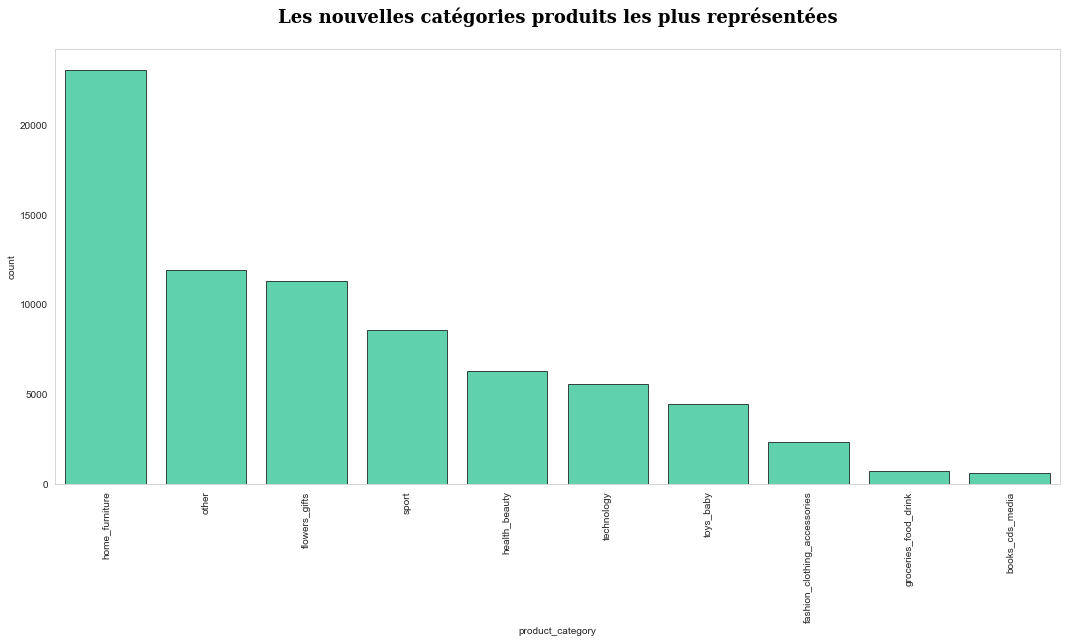

In [140]:
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=df, x="product_category",
              edgecolor="black",
              color="#00d994", 
              order = df['product_category'].value_counts().index,
              alpha=0.7)
plt.xticks(range(0, df["product_category"].nunique()),
           df["product_category"].unique(),
           rotation=90)
plt.title(f"Les nouvelles catégories produits les plus représentées\n",
          fontdict=font_title)
plt.show()

Purchase nb evolution per days

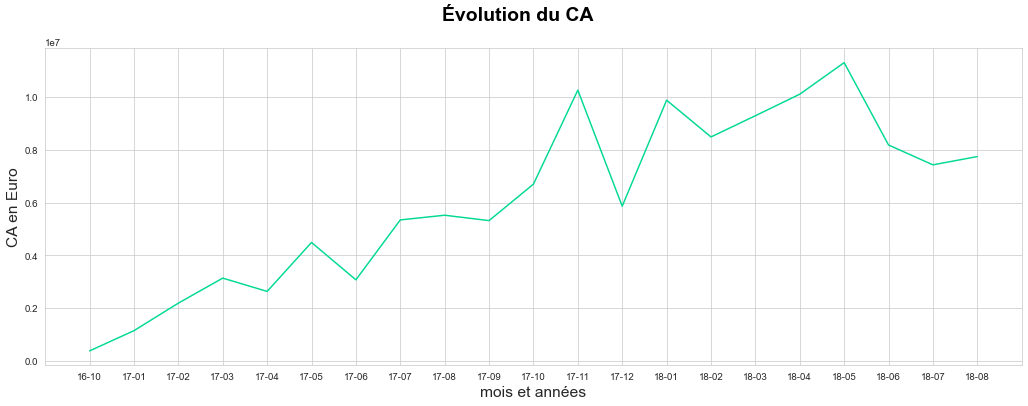

In [199]:
evo_per_month = df.groupby(by=[df['order_purchase_timestamp'].dt.strftime('%y-%m')])['payment_value'].sum().reset_index()
plt.figure(figsize=(18,6), dpi=70).suptitle("Évolution du CA", color='k', fontweight='bold', fontsize=20)
plt.plot(evo_per_month['order_purchase_timestamp'], evo_per_month['payment_value'], color='#00d994')
plt.xlabel('mois et années', fontsize = 16)
plt.ylabel('CA en Euro', fontsize=16)
plt.grid()
plt.show()

Moyens de paiement

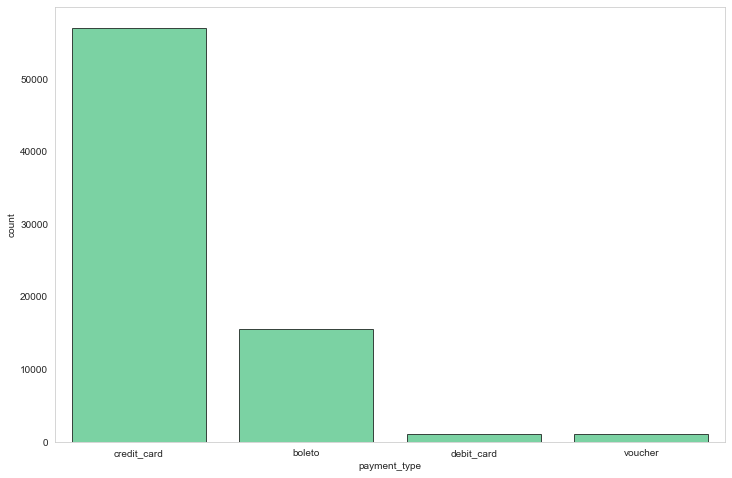

In [142]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(data=df, x="payment_type",
              edgecolor="black",
              color="#2ed47b", 
              order = df['payment_type'].value_counts().index,
              alpha=0.7)
plt.show()

### Notes

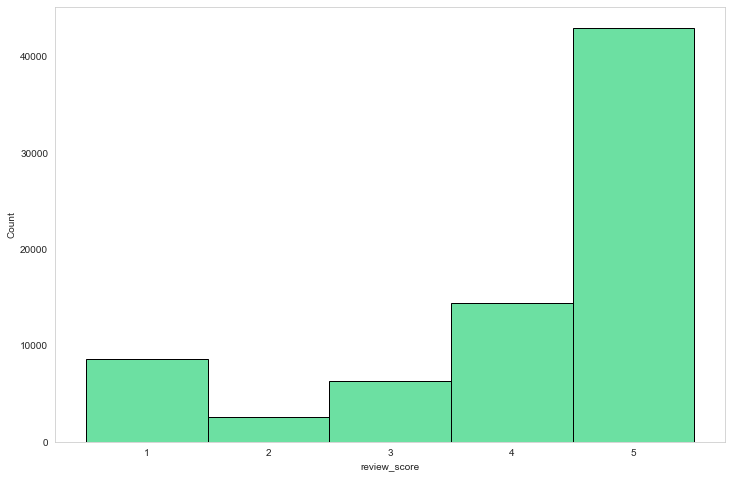

In [143]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=df, x="review_score", 
             discrete=True,
             edgecolor="black",
             color="#2ed47b", 
             alpha=0.7)
plt.show()

# **4 - Analysis**

Delivery rate

In [144]:
df.groupby('order_status')['order_id'].count()

order_status
canceled         3
delivered    74815
Name: order_id, dtype: int64

rating

In [145]:
df['review_score'].mean()

4.076492287952097

Delivery mean nb of days

In [146]:
df["delivery_delta_days"] = (df.order_delivered_customer_date
                               - df.order_purchase_timestamp)\
                              .dt.round('1d').dt.days

df['delivery_delta_days'].mean() 

12.315311823358016

mean order nb per client

In [147]:
mean_order = df['order_item_id'].mean()
mean_order

1.2094549439974338

mean nb items per order 

In [148]:
mean_item_per_order = df['order_item_id'].sum()/df['order_item_id'].count()
mean_item_per_order

1.2094549439974338

mean prices

In [149]:
mean_prices = df['price'].mean()
mean_prices

120.52351279112914

prices description

In [150]:
df['price'].describe()

count    74818.000000
mean       120.523513
std        182.756492
min          0.850000
25%         39.900000
50%         74.900000
75%        135.000000
max       6499.000000
Name: price, dtype: float64

products cat

In [151]:
df['categories'] = np.where(df['price'] < 100,
                            'Low',
                            (np.where(np.logical_and(df['price']>=100, df['price']<=1000),
                                     'Medium',
                                     (np.where(df['price'] > 139, 'High', 'false')))))
df

order_id                       customer_id  \
0      128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
1      0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
2      1e7f171b11eff2ba0ffbf95130c2f18a  4d13014c8bb7cd5fe2d9df4ce2a2d200   
3      807d573c36fdd71594efae0ca1db554e  b2fd5cda6445986a32221a9a29897f67   
4      b7077d240d1449882a2aa143b428b8b2  db41b8d7ff23d40f4002903e0109a136   
...                                 ...                               ...   
74813  e8fa22c3673b1dd17ea315021b1f0f61  1ff773612ab8934db89fd5afa8afe506   
74814  e8fa22c3673b1dd17ea315021b1f0f61  1ff773612ab8934db89fd5afa8afe506   
74815  e8fa22c3673b1dd17ea315021b1f0f61  1ff773612ab8934db89fd5afa8afe506   
74816  e8fa22c3673b1dd17ea315021b1f0f61  1ff773612ab8934db89fd5afa8afe506   
74817  e8fa22c3673b1dd17ea315021b1f0f61  1ff773612ab8934db89fd5afa8afe506   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-08-15 18:29:00 2017-08-15 20:05:00   
1        delivered      2017-08-02 18:24:00 2017-08-02 18:43:00   
2        delivered      2017-07-28 14:08:00 2017-07-28 14:23:00   
3        delivered      2017-07-20 07:30:00 2017-07-20 07:42:00   
4        delivered      2017-10-19 12:50:00 2017-10-21 03:07:00   
...            ...                      ...                 ...   
74813    delivered      2018-04-19 13:54:00 2018-04-20 07:15:00   
74814    delivered      2018-04-19 13:54:00 2018-04-20 07:15:00   
74815    delivered      2018-04-19 13:54:00 2018-04-20 07:15:00   
74816    delivered      2018-04-19 13:54:00 2018-04-20 07:15:00   
74817    delivered      2018-04-19 13:54:00 2018-04-20 07:15:00   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-08-17 15:28:00           2017-08-18 14:44:00   
1              2017-08-04 17:35:00           2017-08-07 18:30:00   
2              2017-07-31 16:16:00           2017-08-03 18:23:00   
3              2017-07-20 14:49:00           2017-07-29 14:18:00   
4              2017-10-23 19:59:00           2017-11-03 17:04:00   
...                            ...                           ...   
74813          2018-04-24 16:08:00           2018-05-03 16:39:00   
74814          2018-04-24 16:08:00           2018-05-03 16:39:00   
74815          2018-04-24 16:08:00           2018-05-03 16:39:00   
74816          2018-04-24 16:08:00           2018-05-03 16:39:00   
74817          2018-04-24 16:08:00           2018-05-03 16:39:00   

      order_estimated_delivery_date  order_item_id  \
0                        2017-08-28              1   
1                        2017-08-15              1   
2                        2017-08-10              1   
3                        2017-08-23              1   
4                        2017-11-08              1   
...                             ...            ...   
74813                    2018-05-22              6   
74814                    2018-05-22              7   
74815                    2018-05-22              8   
74816                    2018-05-22              9   
74817                    2018-05-22             10   

                             product_id  ...   customer_city customer_state  \
0      87285b34884572647811a353c7ac498a  ...       sao paulo             SP   
1      87285b34884572647811a353c7ac498a  ...             NaN            NaN   
2      03b58043df5d7424df7eac2be2511c51  ...       sao paulo             SP   
3      03b58043df5d7424df7eac2be2511c51  ...       fortaleza             CE   
4      03b58043df5d7424df7eac2be2511c51  ...        curitiba             PR   
...                                 ...  ...             ...            ...   
74813  0c9439abe84dc40a64fc164365c4d064  ...  rio de janeiro             RJ   
74814  0c9439abe84dc40a64fc164365c4d064  ...  rio de janeiro             RJ   
74815  0c9439abe84dc40a64fc164365c4d064  ...  rio de janeiro             RJ   
74816  0c9439abe84dc40a64fc164365c4d064  ... 

Products per category

In [152]:
df.groupby('categories')['product_id'].count()

categories
High        575
Low       48098
Medium    26145
Name: product_id, dtype: int64

mean prices per category

In [153]:
df.groupby('categories')['price'].mean()

categories
High      1567.850730
Low         50.956903
Medium     216.671980
Name: price, dtype: float64

wordcloud

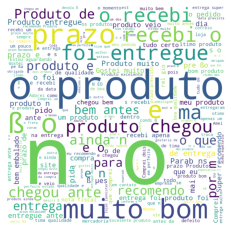

In [154]:
from wordcloud import WordCloud

df_with_review = df[df.review_comment_message != 'No message']
text = df_with_review['review_comment_message']
wordcloud = WordCloud(max_font_size = 400, width = 1080, height = 1080, background_color='white').generate(' '.join(text.astype(str)))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
wordcloud.to_file('output3.png')

# **5- segmentation**

customers per payment_type

In [155]:
df.groupby('payment_type')['customer_id'].count()

payment_type
boleto         15582
credit_card    57086
debit_card      1102
voucher         1048
Name: customer_id, dtype: int64

customers per product category

In [156]:
df.groupby('categories')['customer_id'].count()

categories
High        575
Low       48098
Medium    26145
Name: customer_id, dtype: int64

customers per city

In [157]:
df.groupby('customer_city')['customer_id'].count()

customer_city
abadiania       1
abaete          9
abaetetuba     13
abaiara         2
abaira          1
               ..
xaxim           9
xinguara        4
xique-xique     2
zacarias        1
ze doca         5
Name: customer_id, Length: 3576, dtype: int64

utilisateurs actifs

# **6 - RFM matrix**

Le dataset étant trop vieux, il faut créer une variable contenant la date max de la base de données pour pouvoir calculer la récence

In [158]:
now = df['order_purchase_timestamp'].max()
now

Timestamp('2018-08-29 15:00:00')

In [159]:
df_r = df.groupby(['customer_id'],as_index=False)['order_purchase_timestamp'].max()
df_r.columns = ['customer_id','Last_Purchase_Date']

df_r['Recency'] = df_r.Last_Purchase_Date.apply(lambda x:(now - x).days)
df_r.drop(columns=['Last_Purchase_Date'],inplace=True)
df_r.head()

customer_id  Recency
0  00012a2ce6f8dcda20d059ce98491703      287
1  000161a058600d5901f007fab4c27140      409
2  0002414f95344307404f0ace7a26f1d5      378
3  0004164d20a9e969af783496f3408652      504
4  000598caf2ef4117407665ac33275130       18

In [160]:
df_fm = df.groupby('customer_id').agg({'order_purchase_timestamp'   : lambda x:len(x),
                                         'payment_value'  : lambda x:x.sum()})
df_fm.rename(columns = {'order_purchase_timestamp' :'Frequency',
                           'payment_value':'Monetary'},inplace= True)
df_fm.head()

Frequency  Monetary
customer_id                                          
00012a2ce6f8dcda20d059ce98491703          1    114.74
000161a058600d5901f007fab4c27140          1     67.41
0002414f95344307404f0ace7a26f1d5          1    179.35
0004164d20a9e969af783496f3408652          1     71.80
000598caf2ef4117407665ac33275130          1   1255.71

In [161]:
df_rfm = df_r.merge(df_fm,left_on='customer_id',right_on='customer_id')
df_rfm.head()

customer_id  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703      287          1    114.74
1  000161a058600d5901f007fab4c27140      409          1     67.41
2  0002414f95344307404f0ace7a26f1d5      378          1    179.35
3  0004164d20a9e969af783496f3408652      504          1     71.80
4  000598caf2ef4117407665ac33275130       18          1   1255.71

In [162]:
quantiles = df_rfm.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = df_rfm.copy()

In [163]:
def R(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FM(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [164]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(R, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FM, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FM, args=('Monetary',quantiles))
segmented_rfm.head()

customer_id  Recency  Frequency  Monetary  R_quartile  \
0  00012a2ce6f8dcda20d059ce98491703      287          1    114.74           3   
1  000161a058600d5901f007fab4c27140      409          1     67.41           4   
2  0002414f95344307404f0ace7a26f1d5      378          1    179.35           4   
3  0004164d20a9e969af783496f3408652      504          1     71.80           4   
4  000598caf2ef4117407665ac33275130       18          1   1255.71           1   

   F_quartile  M_quartile  
0           4           2  
1           4           3  
2           4           2  
3           4           3  
4           4           1

In [165]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm.head()

customer_id  Recency  Frequency  Monetary  R_quartile  \
0  00012a2ce6f8dcda20d059ce98491703      287          1    114.74           3   
1  000161a058600d5901f007fab4c27140      409          1     67.41           4   
2  0002414f95344307404f0ace7a26f1d5      378          1    179.35           4   
3  0004164d20a9e969af783496f3408652      504          1     71.80           4   
4  000598caf2ef4117407665ac33275130       18          1   1255.71           1   

   F_quartile  M_quartile RFM_Segment  
0           4           2         342  
1           4           3         443  
2           4           2         442  
3           4           3         443  
4           4           1         141

In [166]:
print("Champions: ",len(segmented_rfm[segmented_rfm['RFM_Segment']=='111']))
print('Loyaux: ',len(segmented_rfm[segmented_rfm['F_quartile']==1]))
print('Nouveaux: ',len(segmented_rfm[segmented_rfm['R_quartile']==1]))
print("Gros dépenseurs: ",len(segmented_rfm[segmented_rfm['M_quartile']==1]))
print('Presque perdus: ', len(segmented_rfm[segmented_rfm['RFM_Segment']=='134']))
print('Perdus: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='344']))
print('Petits dépenseurs perdus: ',len(segmented_rfm[segmented_rfm['RFM_Segment']=='444']))

Champions:  1494
Loyaux:  6712
Nouveaux:  16384
Gros dépenseurs:  16279
Presque perdus:  0
Perdus:  4014
Petits dépenseurs perdus:  4187


# 7- K-means 

In [167]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 0.4518679414183255, : SkewtestResult(statistic=44.9599074111706, pvalue=0.0)
Frequency's: Skew: 7.732944563360473, : SkewtestResult(statistic=250.49639731114019, pvalue=0.0)
Monetary's: Skew: 12.57727748166664, : SkewtestResult(statistic=291.7366033494866, pvalue=0.0)


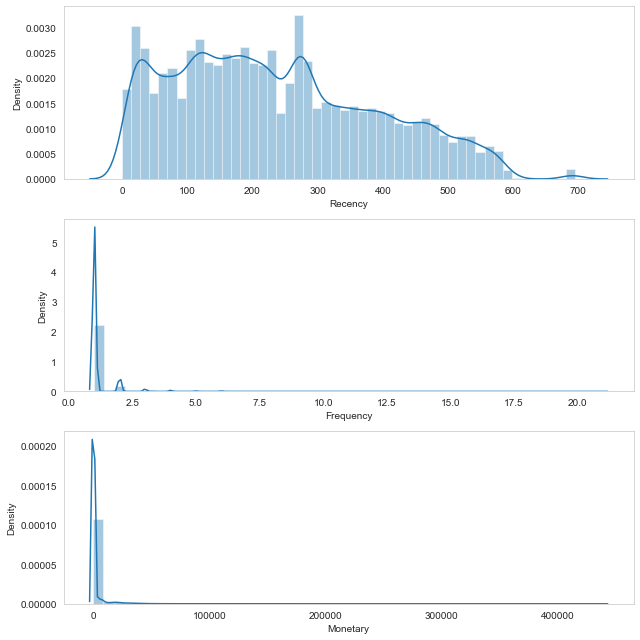

In [168]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm,'Monetary')

plt.tight_layout()

In [169]:
df_rfm_log = df_rfm.copy()
df_rfm_log.head()

customer_id  Recency  Frequency  Monetary
0  00012a2ce6f8dcda20d059ce98491703      287          1    114.74
1  000161a058600d5901f007fab4c27140      409          1     67.41
2  0002414f95344307404f0ace7a26f1d5      378          1    179.35
3  0004164d20a9e969af783496f3408652      504          1     71.80
4  000598caf2ef4117407665ac33275130       18          1   1255.71

Recency's: Skew: -1.2775595908262012, : SkewtestResult(statistic=-104.65559160317034, pvalue=0.0)
Frequency's: Skew: 3.961232714009313, : SkewtestResult(statistic=194.2319450119755, pvalue=0.0)
Monetary's: Skew: 1.8709688590634643, : SkewtestResult(statistic=133.30797423123835, pvalue=0.0)


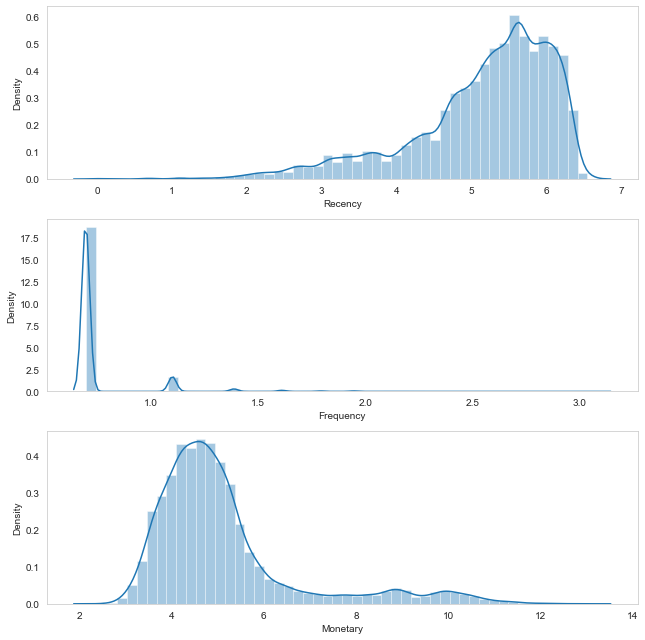

In [170]:
df_rfm_log = np.log(df_rfm_log[['Recency','Frequency','Monetary']]+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()
plt.savefig('Skewness')

In [171]:
df_rfm_log.head()

Recency  Frequency  Monetary
0  5.662960   0.693147  4.751346
1  6.016157   0.693147  4.225519
2  5.937536   0.693147  5.194899
3  6.224558   0.693147  4.287716
4  2.944439   0.693147  7.136252

In [172]:
windsoriser = Winsorizer(tail='both',  
                          fold=2,
                           variables=['Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [173]:
df_rfm_log = windsoriser.transform(df_rfm_log)

In [174]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

df_rfm_scaled = scaler.transform(df_rfm_log)

In [175]:
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=df_rfm_log.columns)
df_rfm_scaled.head()

Recency  Frequency  Monetary
0  0.555109  -0.338986 -0.208552
1  0.966769  -0.338986 -0.607756
2  0.875134  -0.338986  0.128190
3  1.209666  -0.338986 -0.560537
4 -2.262709  -0.338986  1.602051

In [176]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    kmeanModel = KMeans(n_clusters=k).fit(df_rfm_scaled) 
    kmeanModel.fit(df_rfm_scaled)     
      
    distortions.append(sum(np.min(cdist(df_rfm_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_rfm_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_rfm_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df_rfm_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

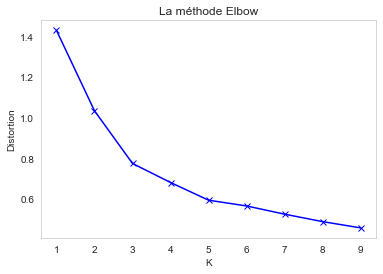

In [177]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('K') 
plt.ylabel('Distortion') 
plt.title('La méthode Elbow') 
plt.savefig('distortion')
plt.show()

In [178]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extraire les labels des clusters 
    cluster_labels = kmeans.labels_
        
    # Creer une colonne avec les labels des différents clusters
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

In [179]:
df_rfm['rand_client_id'] = np.random.randint(1, 65122, df_rfm.shape[0])
df_rfm.head()

customer_id  Recency  Frequency  Monetary  \
0  00012a2ce6f8dcda20d059ce98491703      287          1    114.74   
1  000161a058600d5901f007fab4c27140      409          1     67.41   
2  0002414f95344307404f0ace7a26f1d5      378          1    179.35   
3  0004164d20a9e969af783496f3408652      504          1     71.80   
4  000598caf2ef4117407665ac33275130       18          1   1255.71   

   rand_client_id  
0            8868  
1           62966  
2           64570  
3           61968  
4           49543

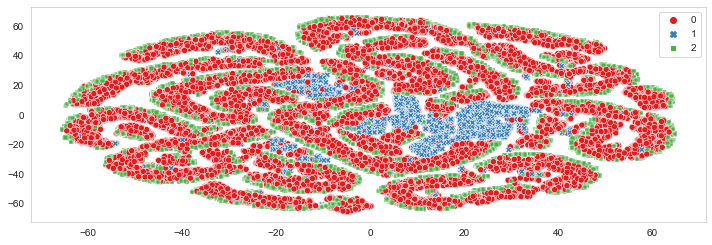

In [180]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(df_rfm_scaled, 3, df_rfm[['rand_client_id','Recency','Frequency','Monetary']])

plt.tight_layout()

In [181]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm.index, 
                                       columns=df_rfm.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['rand_client_id', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

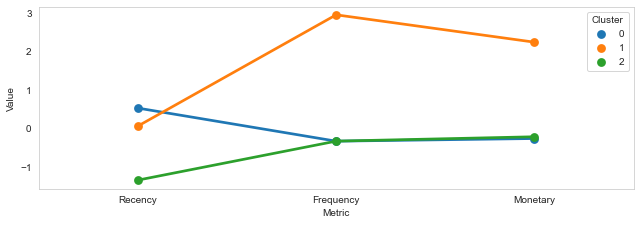

In [182]:
#ce plot sert a avoir une idée sur les différents clusters qu'on obtient ici en analysant les 
#moyennes on voit que le cluster 1 est le best car meilleure récence meilleure fréq et montant
#Le reste si t'es pas con tu comprends 
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
snake_plot(df_rfm_scaled, df_rfm_k3, df_rfm_scaled)

plt.tight_layout()
plt.savefig('Snake plot')
plt.savefig('3 clusters')

In [183]:
import plotly.express as px
import plotly.io as pio
fig = px.scatter_3d(
    data_frame=df_rfm_k3,
    x='Recency',
    y='Frequency',
    z='Monetary',
    color='Cluster',
    log_x=True,
    template='ggplot2',
    title='Clusters 3D',
    labels={'LABEL'},
    hover_name='rand_client_id',
    height=700
)
pio.show(fig)

In [184]:
df_rfm_k3.groupby('Cluster')['rand_client_id'].size()

Cluster
0    41956
1     6707
2    16459
Name: rand_client_id, dtype: int64

In [185]:
df_rfm_k3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65122 entries, 0 to 65121
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rand_client_id  65122 non-null  int64  
 1   Recency         65122 non-null  int64  
 2   Frequency       65122 non-null  int64  
 3   Monetary        65122 non-null  float64
 4   Cluster         65122 non-null  int32  
dtypes: float64(1), int32(1), int64(3)
memory usage: 2.7 MB


In [186]:
df_rfm[['Recency','Monetary']].describe()

Recency       Monetary
count  65122.000000   65122.000000
mean     236.589831    1972.525179
std      153.009774    9635.818594
min        0.000000      10.070000
25%      113.000000      63.000000
50%      217.000000     111.890000
75%      346.000000     216.600000
max      695.000000  440045.500000

In [187]:
df_clustered = df.merge(df_rfm, on='customer_id', how='left')
df_clustered = df_clustered.merge(df_rfm_k3, on='rand_client_id', how='left')
df_clustered = df_clustered[['customer_id','Cluster']]
df_clustered['cluster_name'] = np.where(df_clustered['Cluster'] == 0,
                            'Paresseux',
                                        (np.where(df_clustered['Cluster'] == 1,
                                                 'Crocodiles',
                                                 (np.where(df_clustered['Cluster'] == 2,
                                                          'Tortues', 'false')))))

In [188]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149826 entries, 0 to 149825
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   customer_id   149826 non-null  object
 1   Cluster       149826 non-null  int32 
 2   cluster_name  149826 non-null  object
dtypes: int32(1), object(2)
memory usage: 4.0+ MB


In [189]:
df_clustered.groupby('cluster_name')['customer_id'].nunique()

cluster_name
Crocodiles    12384
Paresseux     52908
Tortues       27365
Name: customer_id, dtype: int64